In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import subprocess
import itertools
import scipy.ndimage

%matplotlib inline

In [2]:
f = subprocess.check_output(["ls"]).split()
files = []
#make list of files that contain ellipse data
for i in f:
    if "ellipseList.txt" in i:
        files.append(i)
print files

['FDDB-fold-01-ellipseList.txt', 'FDDB-fold-02-ellipseList.txt', 'FDDB-fold-03-ellipseList.txt', 'FDDB-fold-04-ellipseList.txt', 'FDDB-fold-05-ellipseList.txt', 'FDDB-fold-06-ellipseList.txt', 'FDDB-fold-07-ellipseList.txt', 'FDDB-fold-08-ellipseList.txt', 'FDDB-fold-09-ellipseList.txt', 'FDDB-fold-10-ellipseList.txt']


In [3]:
imginfo = {}
decimated_imginfo = {}

In [4]:
#container for ellipse data
class ellipse:
    def __init__(self,s,decimated=False):
        ellipse_info = s.split(" ")
        if (decimated):
            axes = [float(ellipse_info[0])/(2*np.sqrt(2)),float(ellipse_info[1])/(2*np.sqrt(2))]
            self.major_axis = max(axes)
            self.minor_axis = min(axes)
            #print axes
            assert self.major_axis >= self.minor_axis
            self.angle = float(ellipse_info[2])
            self.cx = float(ellipse_info[3])/2
            self.cy = float(ellipse_info[4])/2
        else:
            axes = [float(ellipse_info[0]),float(ellipse_info[1])]
            self.major_axis = max(axes)
            self.minor_axis = min(axes)
            #print axes
            assert self.major_axis >= self.minor_axis
            self.angle = float(ellipse_info[2])
            self.cx = float(ellipse_info[3])
            self.cy = float(ellipse_info[4])
        focus = np.sqrt(np.square(self.major_axis)-np.square(self.minor_axis))
        #print focus
        #print self.cx-np.cos(self.angle)*focus
        #print self.cy-np.sin(self.angle)*focus
        #print
        self.foci = np.array([(self.cx-np.cos(self.angle)*focus,self.cy-np.sin(self.angle)*focus),(self.cx+np.cos(self.angle)*focus,self.cy+np.sin(self.angle)*focus)])
        self.foci_dist = np.sqrt(np.square(focus)+np.square(self.minor_axis))
        self.area = np.pi*self.minor_axis*self.major_axis
    def pixel_score(self, xy):
        if (np.linalg.norm([xy[0]-self.foci[0][0],xy[1]-self.foci[0][1]]) + np.linalg.norm([xy[0]-self.foci[1][0],xy[1]-self.foci[1][1]])) <= 2*self.foci_dist:
            #print "For pixel "
            #print xy
            #print "Foci are "
            #print self.foci
            return 1
        return 0
    def score(self, winx, winy, half_width = 16):
        intersect = sum(map(self.pixel_score,itertools.product(xrange(winx-half_width,winx+half_width+1),xrange(winy-half_width,winy+half_width+1))))
        union = np.square(half_width*2+1) + self.area - intersect
        #print intersect/union
        return intersect/union

In [5]:
#read and populate array iminfo with the information about ellipses of images
#images can have variable numbers of ellipses
def info(filename):
    with open(filename,"r") as f:
        while(True):
            try:
                imgpath = f.readline().split("\n")[0]+".jpg"
                imginfo[imgpath] = []
                decimated_imginfo[imgpath] = []
                numfaces = f.readline().strip()
                #print numfaces
                for i in xrange(int(numfaces)):
                    param=f.readline().split("\n")[0]
                    imginfo[imgpath].append(ellipse(param))
                    decimated_imginfo[imgpath].append(ellipse(param,decimated=True))
            except ValueError as e:
                #pass
                return
    return

In [6]:
#store ellipse data for all images
map(info,files)

[None, None, None, None, None, None, None, None, None, None]

In [269]:
#select 5 images
img1 = '2002/07/20/big/img_148.jpg'
img2 = '2003/01/02/big/img_10.jpg'
img3 = '2002/08/01/big/img_1798.jpg'
img4 = '2002/08/22/big/img_192.jpg'
img5 = '2002/08/22/big/img_963.jpg'

selectedImgs = [img1, img2, img3, img4, img5]

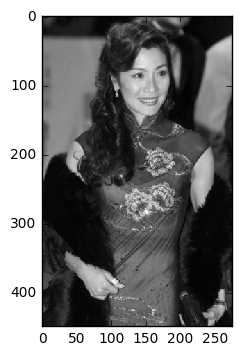

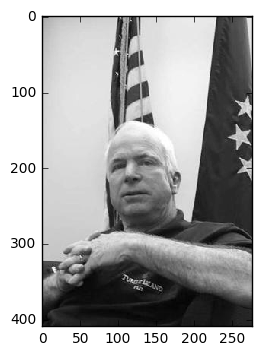

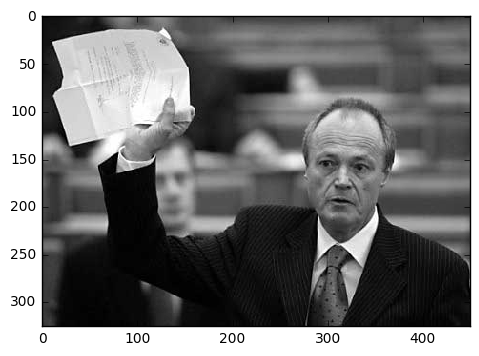

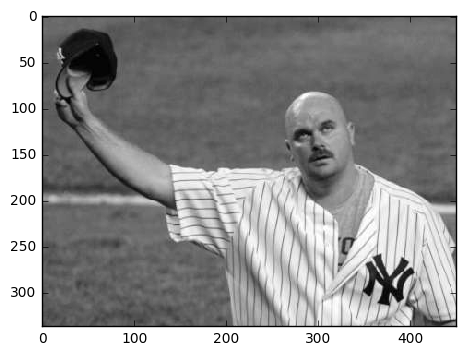

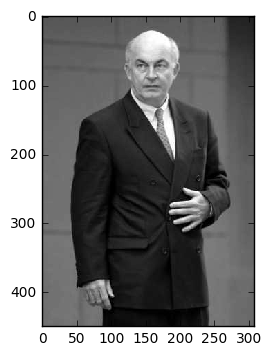

In [270]:
##SHOWING ORIGINAL IMAGES
for im in selectedImgs:
    image = cv2.imread(im,0)
    plt.imshow(image,cmap="gray",interpolation="nearest")
    plt.show()

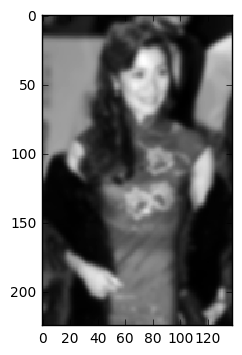

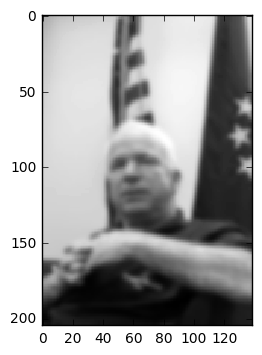

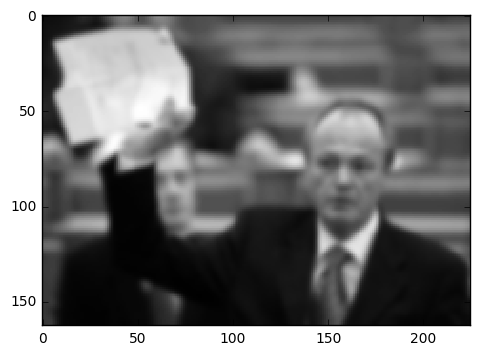

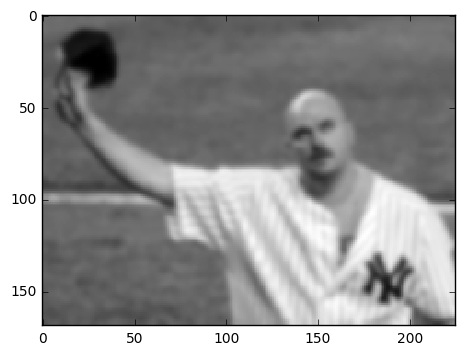

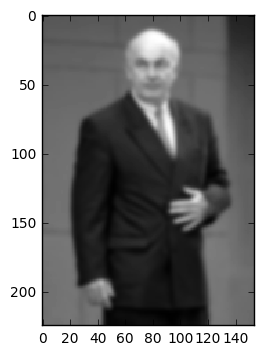

In [271]:
##SHOWING SMALLER IMAGES
for im in selectedImgs:
    image = cv2.imread(im,0)
    image = scipy.ndimage.filters.gaussian_filter(image, sigma=3)
    image = image[::2,::2]
    plt.imshow(image,cmap="gray",interpolation="nearest")
    plt.show()

In [135]:
def create_windows(imfile,e,decimated=False):
    #for ellip in ellipses:
    image = cv2.imread(imfile,0)
    
    if (decimated):
        image = scipy.ndimage.filters.gaussian_filter(image, sigma=3)
        image = image[::2,::2]
    
    positions = [-6,-4,-2,0,2,4,6] #centering of windows
    window_center = list(itertools.product(positions,positions))
    
    #get subsection of image centered at data[1]. data[0] is the ellipse instance for the image
    window_gen = lambda data: image[int(data[0].cy+data[1][1]) - 16:int(data[0].cy+data[1][1]) + 17,int(data[0].cx+data[1][0]) - 16:int(data[0].cx+data[1][0]) + 17]
    
    #get scoring information for each window
    scoring = lambda data: data[0].score(int(data[0].cx+data[1][0]),int(data[0].cy+data[1][1])) #implement the scoring function
    
    report = lambda data: [window_gen(data),scoring(data)]
    
    #get images for all windows for all image files
    scored_data = map(report,itertools.product(e,window_center))
    
    #DEBUG: check if images have >1 ellipses
    #if len(e)>1:
    #    print len(windows)
    #print "Done with image file %s"%imfile
    return scored_data

In [199]:
def create_random_windows(img_name, decimated = False):
    image = cv2.imread(img_name,0) #read the image
    rects = [] # list to store windows
    rects_count = 0 # windows count
    ellipses_positions = [] # list storing top_left.x, top_left.y, bot_right.x, bot_right.y of the window
   
    if (decimated):
        info = decimated_imginfo
    else:
        info = imginfo
    # Generate rectangles for ellipses
    for ellipses in info[img_name]:
        l1_x = ellipses.cx - ellipses.major_axis
        l1_y = ellipses.cx - ellipses.major_axis
 
        r1_x = ellipses.cx + ellipses.major_axis
        r1_y = ellipses.cy + ellipses.major_axis
 
        corners = [l1_x,l1_y,r1_x,r1_y]
        ellipses_positions.append(corners)
 
    # Generate 32 x 32 windows and check whether each intersects any of the ellipses' rectangles
      # add to list if it does not
    for x in range(0,image.shape[0]+1-32, 8):
        for y in range(0,image.shape[1]+1-32, 8):
            l2_x = x
            l2_y = y
 
            r2_x = x + 32
            r2_y = y + 32  
 
            intersect = False
            for corners in ellipses_positions:
                l1_x = corners[0]
                l1_y = corners[1]
                r1_x = corners[2]
                r1_y = corners[3]  
 
                if not (l1_x > r2_x or l2_x > r1_x  or l1_y < r2_y or l2_y < r1_y):                    
                    intersect = True
                    break                  
                   
            if not intersect:
                rects.append(image[l2_y:r2_y,l2_x:r2_x])
                rects_count += 1
 
            if rects_count >= 49:
                return rects

0.0476353271306


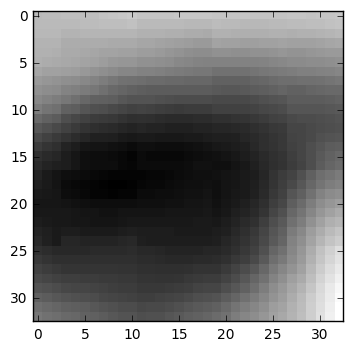

In [138]:
###SAMPLE CODE####

#get image squares for all images
image_windows = lambda i: create_windows(imginfo.keys()[i],imginfo[imginfo.keys()[i]])
#all_image_windows = map(image_windows,xrange(len(imginfo)))
all_image_windows = map(image_windows,xrange(1))
#get image squares for all images
#using imginfo.keys() to keep the same order
decimated_image_windows = lambda i: create_windows(imginfo.keys()[i],decimated_imginfo[imginfo.keys()[i]],decimated=True)
decimated_all_image_windows = map(decimated_image_windows,xrange(1))

#nonface windows
nonFaceWindows = map(create_random_windows,selectedImgs)

def show(i,decimated=False):
    if (decimated):
        print decimated_all_image_windows[i][0][1]
        plt.imshow(decimated_all_image_windows[i][0][0],cmap="gray",interpolation='nearest')
    else:
        print all_image_windows[i][0][1]
        plt.imshow(all_image_windows[i][0][0],cmap="gray",interpolation="nearest")
    plt.show()
    
for i in xrange(1):
    show(i)
    
    

In [205]:
image_windows = lambda i: create_windows(selectedImgs[i],imginfo[selectedImgs[i]])
decimated_image_windows = lambda i: create_windows(selectedImgs[i],decimated_imginfo[selectedImgs[i]],decimated=True)

full_image_windows = map(image_windows,xrange(5))
decimated_image_windows = map(decimated_image_windows,xrange(5))

full_nonface_windows = map(create_random_windows,selectedImgs)
decimated_nonface = lambda img: create_random_windows(img,True)
decimated_nonface_windows = map(decimated_nonface, selectedImgs)

In [211]:
full_image_windows[0][0][1]

0.16419842721583799

In [212]:
49/2

24

In [263]:
len(full_nonface_windows[2])

49

In [236]:
def display3Faces(windows):
    for i in range(len(windows)):
        print("=================NEW IMAGE===================\n")
        scores = [windows[i][s][1] for s in xrange(49)]
        #index order of each score
        indx = np.argsort(scores)
        #show highest score
        plt.imshow(windows[i][indx[48]][0],cmap="gray",interpolation="nearest")
        plt.title('highest score {}'.format(scores[indx[48]]))
        plt.show()
        
        #show median score
        plt.imshow(windows[i][indx[24]][0],cmap="gray",interpolation="nearest")
        plt.title('median score {}'.format(scores[indx[24]]))
        plt.show()
        
        #show lowest score
        plt.imshow(windows[i][indx[0]][0],cmap="gray",interpolation="nearest")
        plt.title('lowest score {}'.format(scores[indx[0]]))
        plt.show()

In [252]:
len(full_nonface_windows[1])

49

In [264]:
def display3Random(windows):
    for i in range(len(windows)):
        print("=================NEW IMAGE===================\n")
        plt.imshow(windows[i][0],cmap="gray",interpolation="nearest")
        plt.show()
        plt.imshow(windows[i][5],cmap="gray",interpolation="nearest")
        plt.show()
        plt.imshow(windows[i][10],cmap="gray",interpolation="nearest")
        plt.show()

=================NEW IMAGE===================



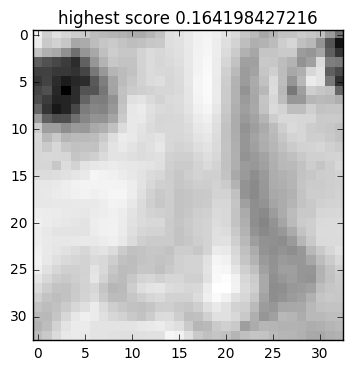

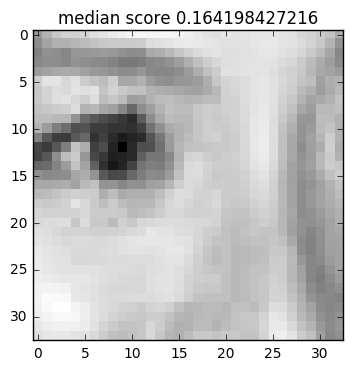

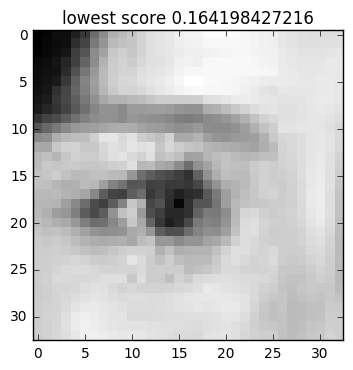

=================NEW IMAGE===================



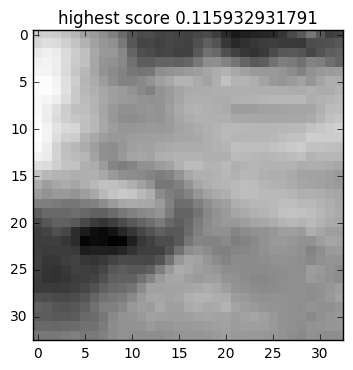

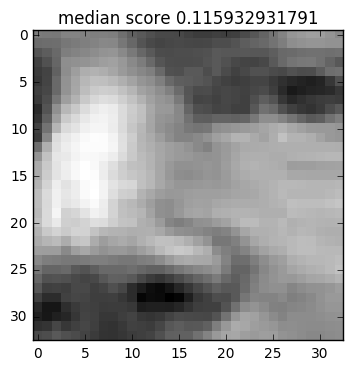

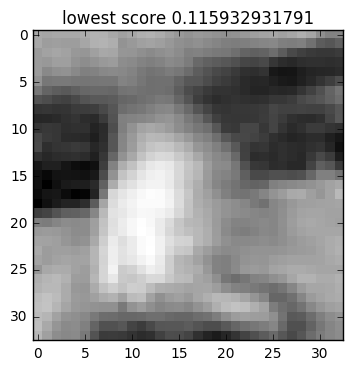

=================NEW IMAGE===================



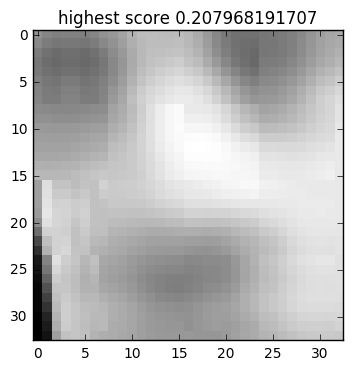

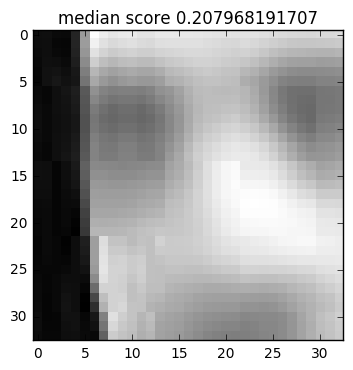

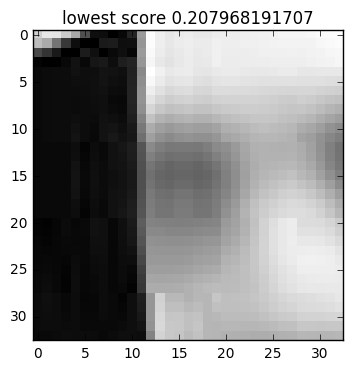

=================NEW IMAGE===================



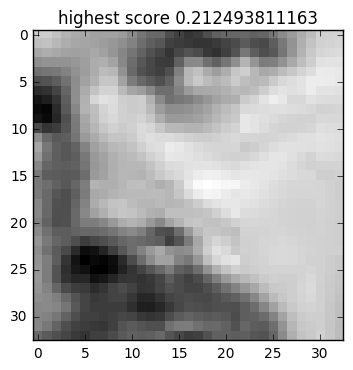

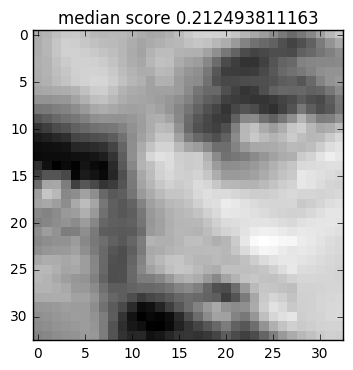

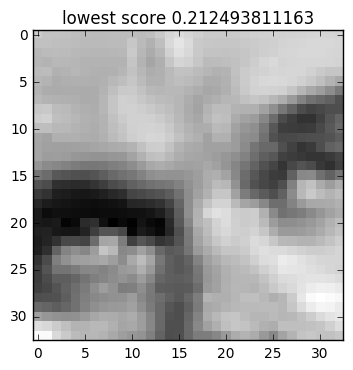

=================NEW IMAGE===================



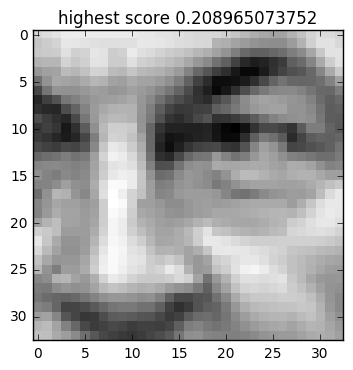

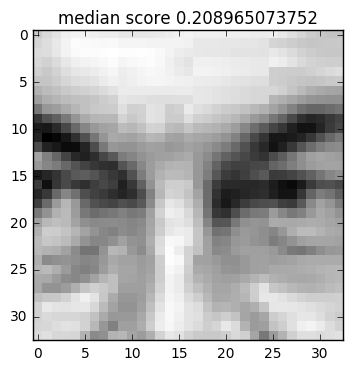

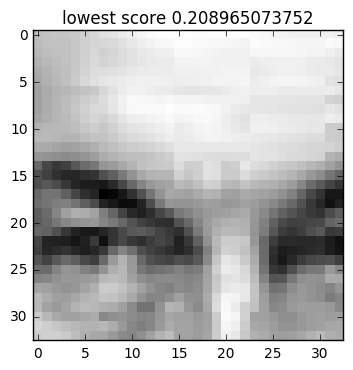

In [265]:
###display full sized images####
display3Faces(full_image_windows)

=================NEW IMAGE===================



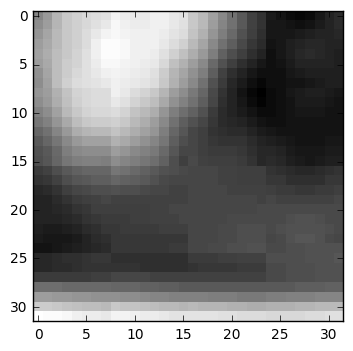

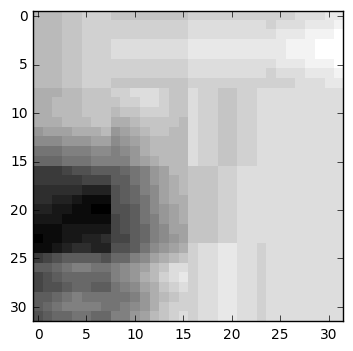

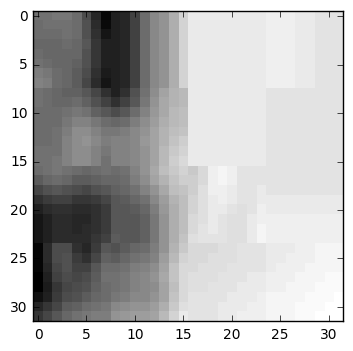

=================NEW IMAGE===================



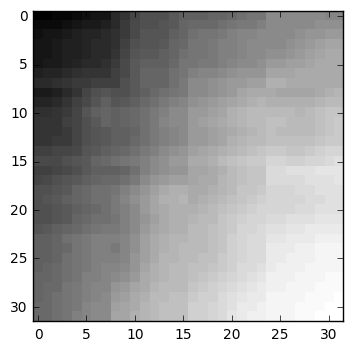

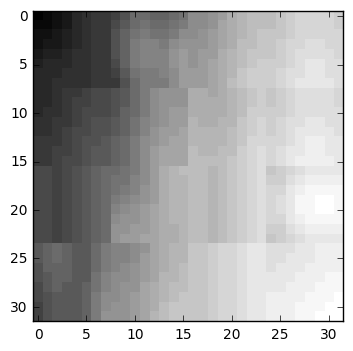

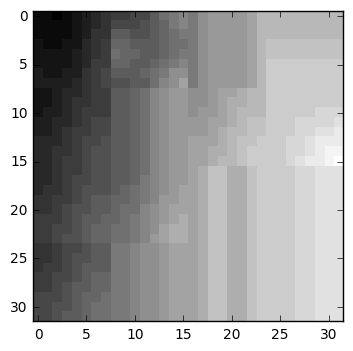

=================NEW IMAGE===================



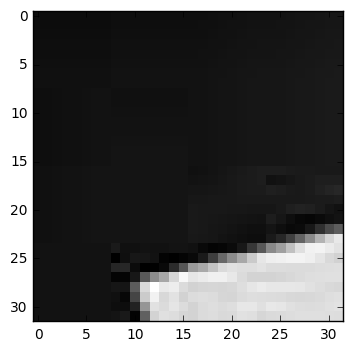

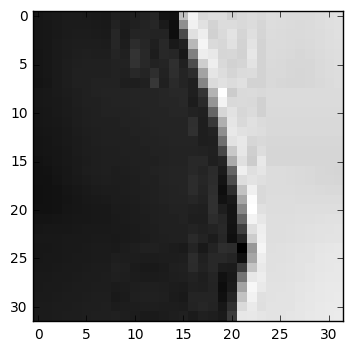

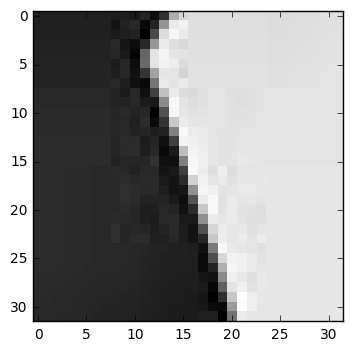

=================NEW IMAGE===================



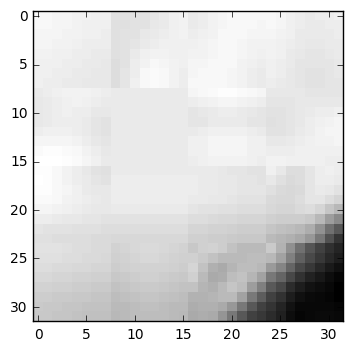

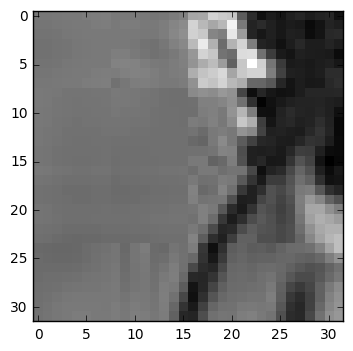

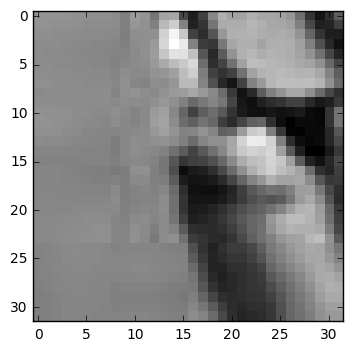

=================NEW IMAGE===================



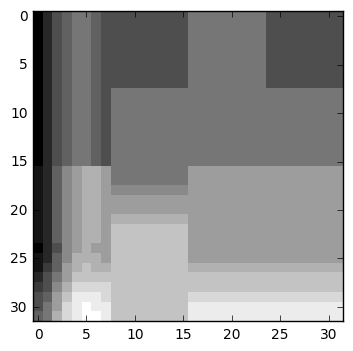

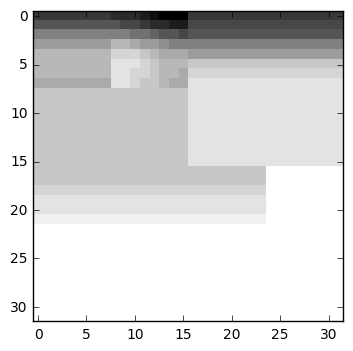

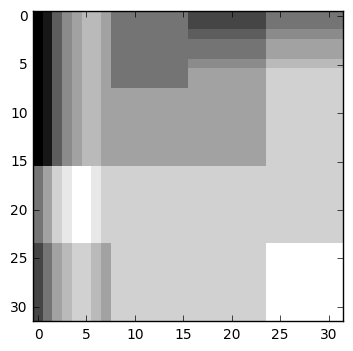

In [266]:
###non-face images full size shown in the same order###
display3Random(full_nonface_windows)

=================NEW IMAGE===================



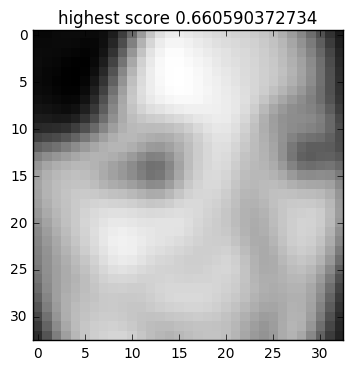

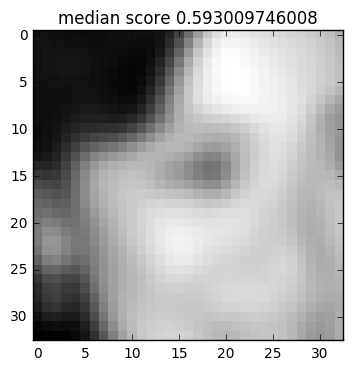

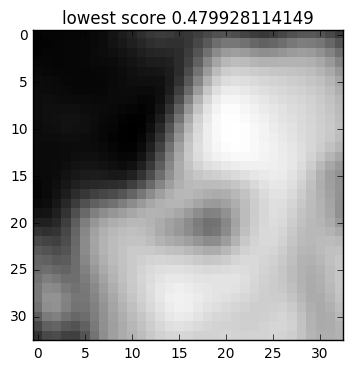

=================NEW IMAGE===================



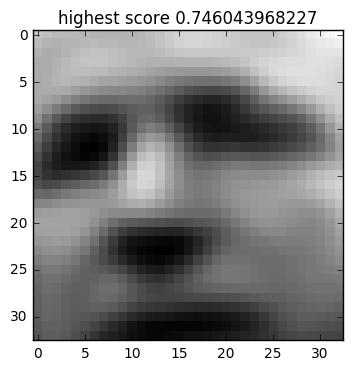

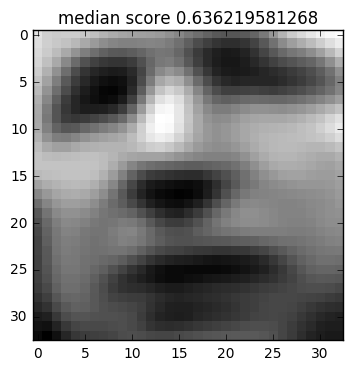

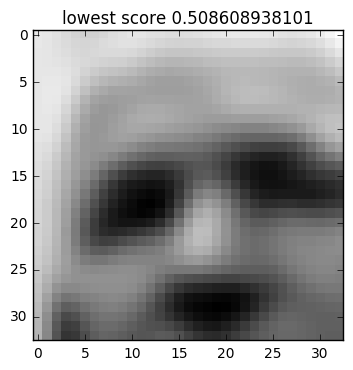

=================NEW IMAGE===================



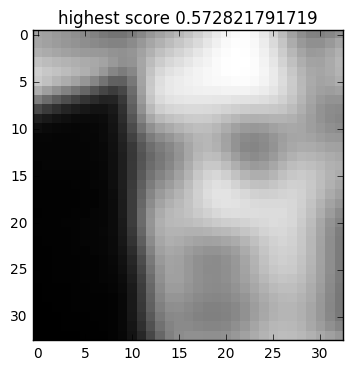

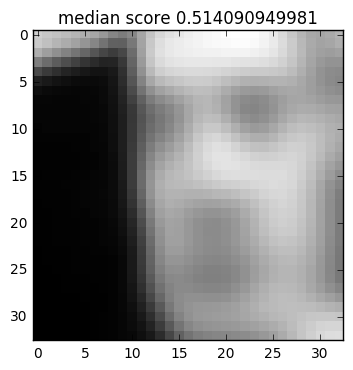

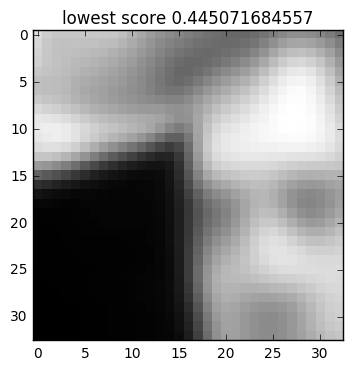

=================NEW IMAGE===================



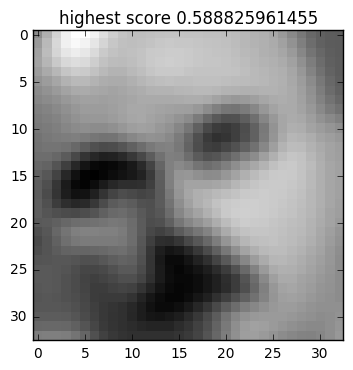

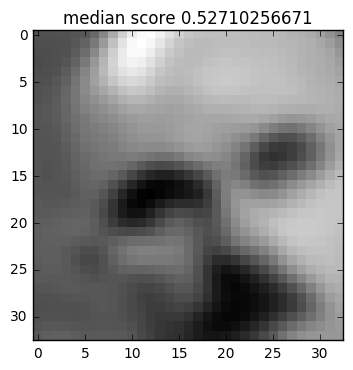

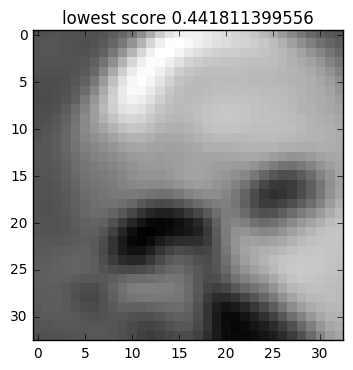

=================NEW IMAGE===================



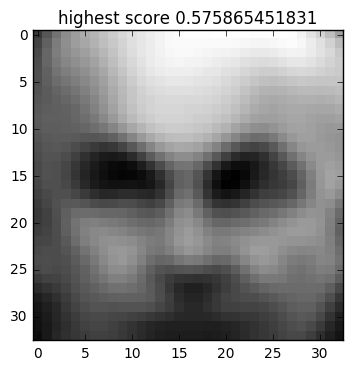

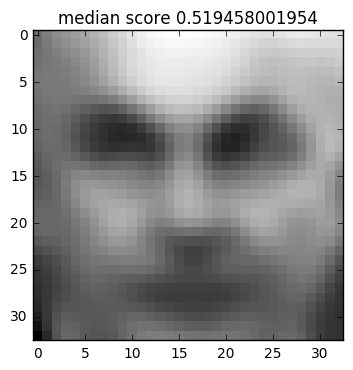

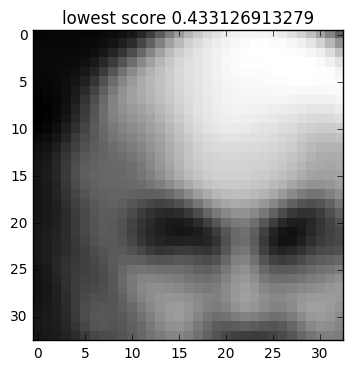

In [267]:
###display decimated images####
display3Faces(decimated_image_windows)

=================NEW IMAGE===================



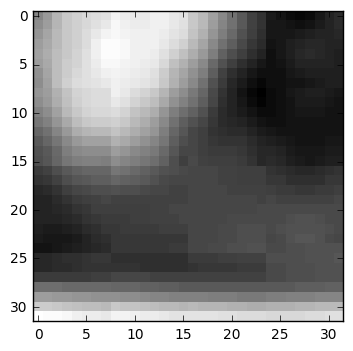

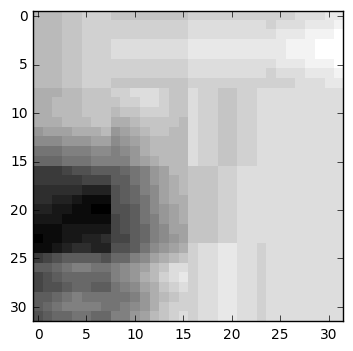

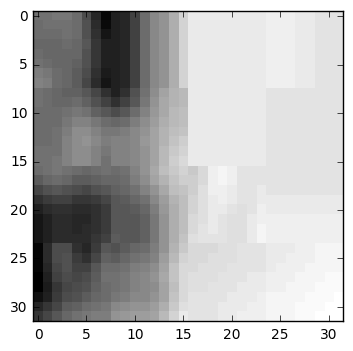

=================NEW IMAGE===================



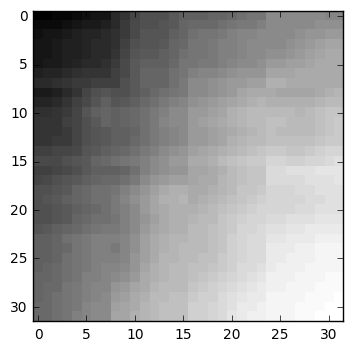

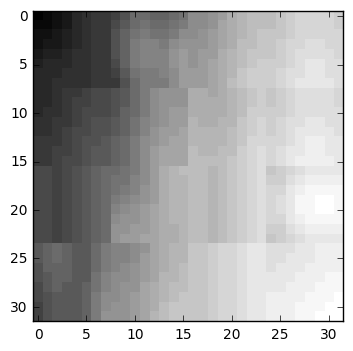

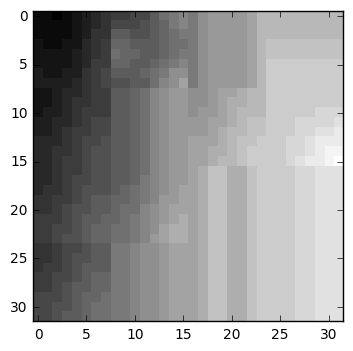

=================NEW IMAGE===================



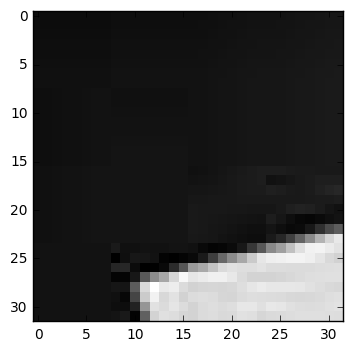

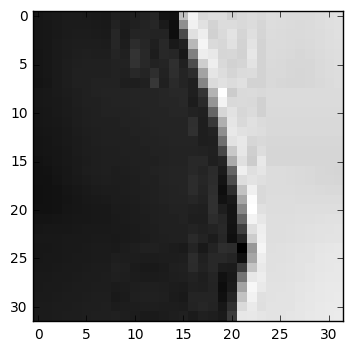

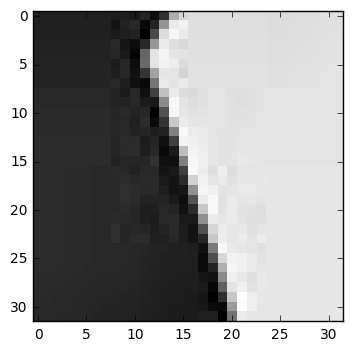

=================NEW IMAGE===================



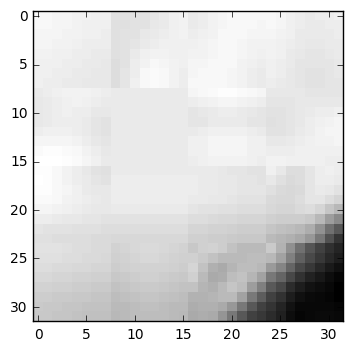

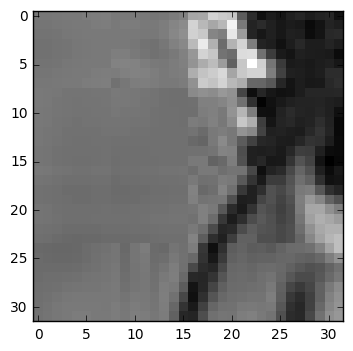

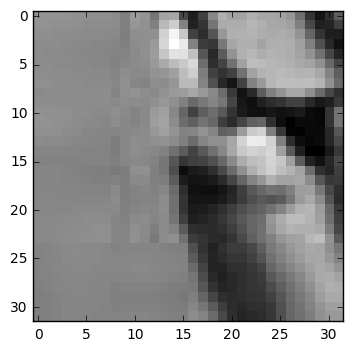

=================NEW IMAGE===================



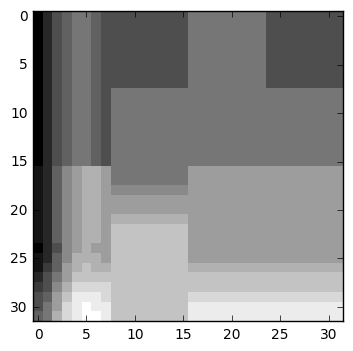

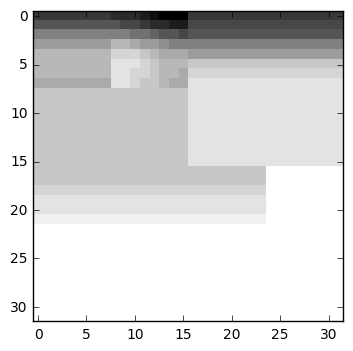

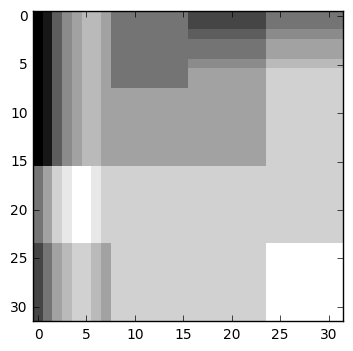

In [268]:
###non-face images full size shown in the same order###
display3Random(decimated_nonface_windows)